# Analysis by using a second video

In [1]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.auto import tqdm
from joblib import Parallel, delayed
import pandas as pd
import toml

from IPython.display import display, clear_output, HTML
import base64

In [2]:
_working_dir = os.path.abspath('../../')
_data_dir = "data"
_fov = 160
_working_dir

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python'

# Calibration path

In [3]:
_calibration_folder = 'calib_mono_160fov_raw'
_calibration_folder = os.path.join(_data_dir, "calibration", f"{_fov}_fov", _calibration_folder)
_calibration_file_path = os.path.join(_working_dir, _calibration_folder, 'webcam_color.msgpack')
_calibration_file_path

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python\\data\\calibration\\160_fov\\calib_mono_160fov_raw\\webcam_color.msgpack'

In [4]:
# Alternatively import calibration parameters from toml file
_toml_pth = os.path.join(_working_dir, 'optimized_fisheye_calibration.toml')
_toml_pth

'e:\\CMC\\pyprojects\\programs_rpi\\rpi_python\\optimized_fisheye_calibration.toml'

# Movement data path / April tag recording path

In [5]:
_folder_name = 'randomxyz_t0'
_semi_parent = '3marker_complete_data'

_recording_folder = os.path.join(_working_dir,_data_dir, "recordings",f'{_fov}_fov', _semi_parent, _folder_name)
_movement_data_path = os.path.join(_recording_folder, 'webcam_color.msgpack')

In [6]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_movement_data_path, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [7]:
timestamp_file = os.path.join(_recording_folder, 'webcam_timestamp.msgpack')
_ar_timestamp = list(mp.Unpacker(open(timestamp_file, "rb"), object_hook=mpn.decode))
# _ar_timestamp = np.array(_ar_timestamp)

In [8]:
_sync = np.array(_ar_timestamp).T[0]
_sync = _sync.astype(int)
_timestamps = np.array(_ar_timestamp).T[1]

In [9]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [10]:
_optimization_file = r"E:\CMC\pyprojects\programs_rpi\rpi_python\data\calibration\160_fov\calib_mono_160fov_raw\optimization_file_2000.msgpack"
_optimum = list(mp.Unpacker(open(_optimization_file, "rb"), object_hook=mpn.decode))

In [11]:
_calibration_data = r"E:\CMC\pyprojects\programs_rpi\rpi_python\data\calibration\160_fov\calib_mono_160fov_raw\calibration_data_2000.msgpack"
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [142]:
matrix = _calib_data[0]['mat'][10]
distortion = _calib_data[0]['dist'][10]

# Using the three marker setup
matrix = _calib_data[0]['mat'][1625]
distortion = _calib_data[0]['dist'][1625]

# matrix = _calib_data[0]['mat'][1470 ]
# distortion = _calib_data[0]['dist'][1470 ]

# 2000 optimization minimum error point
matrix = _calib_data[0]['mat'][1810]
distortion = _calib_data[0]['dist'][1810]

In [143]:
# matrix = np.array([[583.74896, 0. , 655.6217 ],
#                     [  0.     , 587.4526 , 334.6328 ],
#                     [  0.        , 0.,         1.     ]], dtype=np.float32)

# distortion = np.array([[-0.0454573 ],
#  [ 0.04474313],
#  [-0.06101144],
#  [ 0.0247249 ]], dtype=np.float32)

In [144]:
# _calib_data[11000]
# np.argmin((_calib_data[0][1]['median_sum']))
# _calib_data

In [145]:
# _calib_data[0][0]['ar_data']

In [146]:
# _calib_data = toml.load(_toml_pth)

# matrix = np.array(_calib_data['calibration']['camera_matrix'], dtype=np.float32).reshape(3, 3)
# distortion = np.array(_calib_data['calibration']['dist_coeffs'], dtype=np.float32)

In [147]:
# _calib_data

_new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    matrix, distortion, (1200, 800), np.eye(3))
_new_matrix

array([[462.88357637,   0.        , 750.85352989],
       [  0.        , 465.3957314 , 301.50284046],
       [  0.        ,   0.        ,   1.        ]])

In [148]:
def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

In [149]:

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': [], 'rvecs': [], 'tvecs': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[]}


_frames = mp.Unpacker(open(_movement_data_path, "rb"), object_hook=mpn.decode)

for idx, _frame in tqdm(enumerate(_frames)):
    # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    _frame = cv2.flip(_frame, 1)
    res = detector.detectMarkers(_frame,)
    
    res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
    
    corners = undistort_aruco_corners_fisheye(res[0], matrix, distortion)
    
    # res[0] = cv2.undistortPoints(
    #     res[0], matrix, distortion, P=_new_matrix)
    
    ar_results['corners'].append(corners)
    ar_results['ids'].append(res[1].T.reshape(-1))
    ar_results['rejected'].append(res[2])
    
    if res[0] is not None and len(res[0]) > 0:
        rvecs, tvecs = estimate_pose_single_markers(
            corners, markerLength, matrix, distortion
        )
        
        # rvecs, tvecs = estimate_pose_single_markers(
        #     res[0], markerLength, _new_matrix, np.zeros((5, 1))
        # )
        
        ar_results['rvecs'].append(rvecs)
        ar_results['tvecs'].append(tvecs)
    
    # if idx in _random_reference_frames_idx:
    #     _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    #     _ref_frames.append(_frame)


0it [00:00, ?it/s]

In [150]:
ar_results['ids'][0]

array([12, 20, 14], dtype=int32)

In [151]:
import numpy as np
import cv2

# Initialize the dictionary to store transformed translation vectors
transformed_tvec = {'12': [], '14': [], '20': []}
target_ids = [12, 14, 20]  # IDs we're interested in

for _id in range(len(ar_results['ids'])):
    sorted_ids = np.sort(ar_results['ids'][_id])
    sorted_id_index = np.argsort(ar_results['ids'][_id])
    _corners = np.array(ar_results['corners'][_id])[sorted_id_index]
    _rvecs = ar_results['rvecs'][_id][sorted_id_index]
    _tvecs = ar_results['tvecs'][_id][sorted_id_index]
   
    if _id == 0:
        # Store initial reference frame (assuming first detected marker)
        initial_rmat = cv2.Rodrigues(_rvecs[0])[0]
        initial_tvec = _tvecs[0]
    else:
        # Transform all detected markers to reference frame
        _temp_vec = _tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        _temp = (initial_rmat.T @ _temp_vec).T
        
        # Create a mapping from detected IDs to their transformed positions
        id_to_position = {}
        for i, marker_id in enumerate(sorted_ids):
            id_to_position[marker_id] = _temp[i]
        
        # For each target ID, append the transformed position or NaN if not detected
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))

# Alternative approach using a more flexible data structure
def process_aruco_detections(ar_results, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if ar_results['ids'][frame_idx] is None or len(ar_results['ids'][frame_idx]) == 0:
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
            
        # Sort detections by ID for consistency
        sorted_indices = np.argsort(ar_results['ids'][frame_idx])
        sorted_ids = ar_results['ids'][frame_idx][sorted_indices]
        sorted_rvecs = ar_results['rvecs'][frame_idx][sorted_indices]
        sorted_tvecs = ar_results['tvecs'][frame_idx][sorted_indices]
        
        # Initialize reference frame from first detection
        if initial_rmat is None:
            initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
            initial_tvec = sorted_tvecs[0]
            # For the first frame, just fill with NaN (or zeros if preferred)
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Transform all detected markers to reference frame
        temp_vec = sorted_tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        transformed_positions = (initial_rmat.T @ temp_vec).T
        
        # Create mapping from ID to transformed position
        id_to_position = dict(zip(sorted_ids, transformed_positions))
        
        # Append results for each target ID
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

# Usage example:
# transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])

# For handling NaN values later in your analysis:
def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

In [152]:
transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])
transformed_tvec = clean_transformed_data(transformed_tvec)

In [153]:
len(_timestamps), len(transformed_tvec['12']['positions']), 

(2861, 2860)

In [154]:
_start_pulse = 0
_end_pulse = 0
for idx, _s in enumerate(_sync):
    if _s == 1:
        _start_pulse = idx
        break
for idx, _s in enumerate(_sync[_start_pulse:]):
    if _s == 0:
        _end_pulse = idx
        break


In [155]:
_time_df = pd.DataFrame({
    'time': _timestamps[:len(transformed_tvec['12']['positions'])],
    '12_x': transformed_tvec['12']['positions'][:, 0],
    '12_y': transformed_tvec['12']['positions'][:, 1],
    '12_z': transformed_tvec['12']['positions'][:, 2],
    # '14_x': transformed_tvec['14']['positions'][:, 0],
    # '14_y': transformed_tvec['14']['positions'][:, 1],
    # '14_z': transformed_tvec['14']['positions'][:, 2],
    # '20_x': transformed_tvec['20']['positions'][:, 0],
    # '20_y': transformed_tvec['20']['positions'][:, 1],
    # '20_z': transformed_tvec['20']['positions'][:, 2],
})
# convert time column to datetime
_time_df['time'] = pd.to_datetime(_time_df['time'])
# _time_df = _time_df[_start_pulse:_end_pulse].reset_index()
_time_df = _time_df[_start_pulse:].reset_index()

In [156]:
print(np.linalg.norm(transformed_tvec['12']['positions'][0] - transformed_tvec['14']['positions'][0]))
print(np.linalg.norm(transformed_tvec['14']['positions'][0] - transformed_tvec['20']['positions'][0]))
print(np.linalg.norm(transformed_tvec['20']['positions'][0] - transformed_tvec['12']['positions'][0]))



0.09167240836268083
0.08170979368721311
0.09102117715505637


# mocap path

In [157]:
import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *
_mocap_pth = os.path.join(os.path.dirname(_movement_data_path), f"{_folder_name}.csv")

mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, 'seconds')


_time_offset = _time_df['time'][0] - mocap_df['time'][0]

_time_df['time'] = _time_df['time'] - _time_offset

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [158]:
rb_quat = mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].values
rb_pos = mocap_df[['rb_pos_x', 'rb_pos_y', 'rb_pos_z']].values

In [159]:
from scipy.spatial.transform import Rotation as R
rb_matrix = R.from_quat(rb_quat[0]).as_matrix()

In [160]:
transformed_rb_pos = (rb_matrix.T @ (rb_pos.T - rb_pos[0].reshape(3,1))).T
rotation_correction = R.from_euler('xyz', [90, 0, 0], degrees=True).as_matrix()
transformed_rb_pos = (rotation_correction.T @ transformed_rb_pos.T).T

# Interpolation

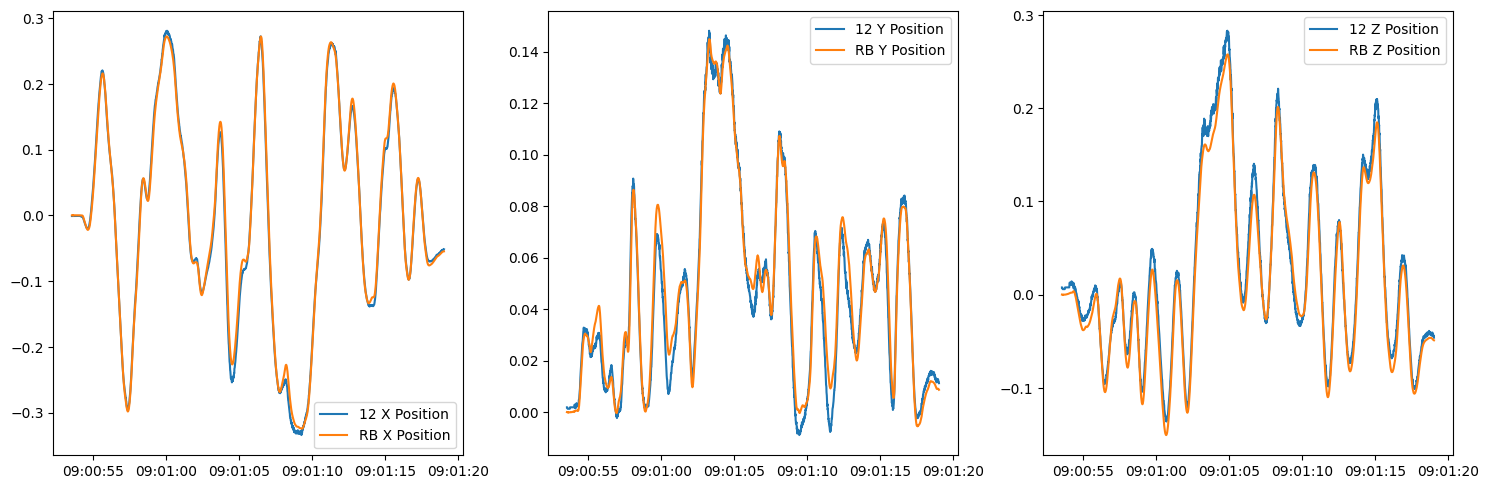

In [161]:
from scipy.interpolate import interp1d

_cols = ['12_x', '12_y', '12_z']

_ar_df = pd.DataFrame()
for _col in _cols:
    _interp_func = interp1d(
        _time_df['time'].astype(np.int64), 
        _time_df[_col], 
        bounds_error=False, 
        fill_value='extrapolate'
    )
    
    _ar_df[_col] = _interp_func(mocap_df['time'].astype(np.int64))
    
# 3, 1 subplot 

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)

# Plot X positions
plt.plot(mocap_df['time'], -1*_ar_df['12_x'], label='12 X Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[0], label='RB X Position')
plt.legend()
plt.subplot(1, 3, 2)
# Plot Y positions
plt.plot(mocap_df['time'], _ar_df['12_y'], label='12 Y Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[1], label='RB Y Position')
plt.legend()
plt.subplot(1, 3, 3)
# Plot Z positions
plt.plot(mocap_df['time'], -_ar_df['12_z'], label='12 Z Position')
plt.plot(mocap_df['time'], transformed_rb_pos.T[2], label='RB Z Position')
plt.legend()
plt.tight_layout()

In [162]:
# # Enable msgpack to decode numpy arrays
# mpn.patch()
# with open(_movement_data_path, 'rb') as f:
#     unpacker = mp.Unpacker(f, object_hook=mpn.decode, raw=False)

#     for frame in unpacker:
#         img_rgb = cv2.cvtColor(cv2.resize(frame, (600,400)), cv2.COLOR_BGR2RGB)
#         _, jpeg = cv2.imencode('.jpg', img_rgb)
#         b64 = base64.b64encode(jpeg.tobytes()).decode()
#         clear_output(wait=True)
#         display(HTML(f'<img src="data:image/jpeg;base64,{b64}"/>'))

# Error plots

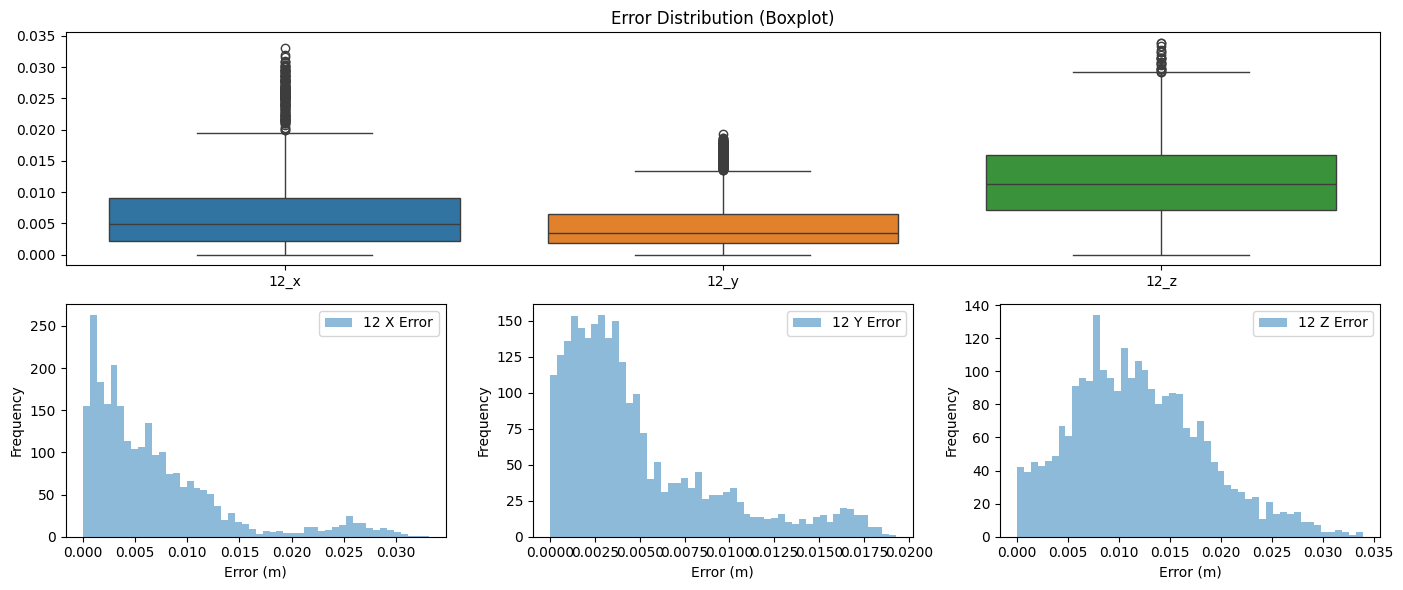

In [163]:

error_df = pd.DataFrame({
    '12_x': np.abs(-1*_ar_df['12_x'] - transformed_rb_pos.T[0]),
    '12_y': np.abs(_ar_df['12_y'] - transformed_rb_pos.T[1]),
    '12_z': np.abs(-_ar_df['12_z'] - transformed_rb_pos.T[2]),
})

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])  # 2 rows, 3 columns

# First row: span all 3 columns
ax_box = fig.add_subplot(gs[0, :])
sns.boxplot(data=error_df, ax=ax_box)
ax_box.set_title("Error Distribution (Boxplot)")

# Second row: 3 histograms
ax1 = fig.add_subplot(gs[1, 0])
ax1.hist(error_df['12_x'], bins=50, alpha=0.5, label='12 X Error')
ax1.set_xlabel('Error (m)')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2 = fig.add_subplot(gs[1, 1])
ax2.hist(error_df['12_y'], bins=50, alpha=0.5, label='12 Y Error')
ax2.set_xlabel('Error (m)')
ax2.set_ylabel('Frequency')
ax2.legend()

ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(error_df['12_z'], bins=50, alpha=0.5, label='12 Z Error')
ax3.set_xlabel('Error (m)')
ax3.set_ylabel('Frequency')
ax3.legend()

plt.tight_layout()
plt.show()


In [164]:
import numpy as np
vector = np.array([-1*_ar_df['12_x'], _ar_df['12_y'], -_ar_df['12_z']])
error = transformed_rb_pos.T - vector

x_distance = -1*_ar_df['12_x'][0] - -1*_ar_df['12_x']
y_distance = _ar_df['12_y'][0] - _ar_df['12_y']
z_distance = -_ar_df['12_z'][0] - -_ar_df['12_z']

vector_distance = np.linalg.norm([x_distance, y_distance, z_distance], axis=0)

In [165]:
# Build AR vector correctly as (N, 3)
vector = np.column_stack([
    -1 * _ar_df['12_x'],
     _ar_df['12_y'],
    -1 * _ar_df['12_z']
])

# Compute error (same shape N x 3)
error = transformed_rb_pos - vector

# Error components
error_x = error[:, 0]
error_y = error[:, 1]
error_z = error[:, 2]

# Distance from first frame
ref_vec = vector[0]
vector_distance = np.linalg.norm(vector - ref_vec, axis=1)


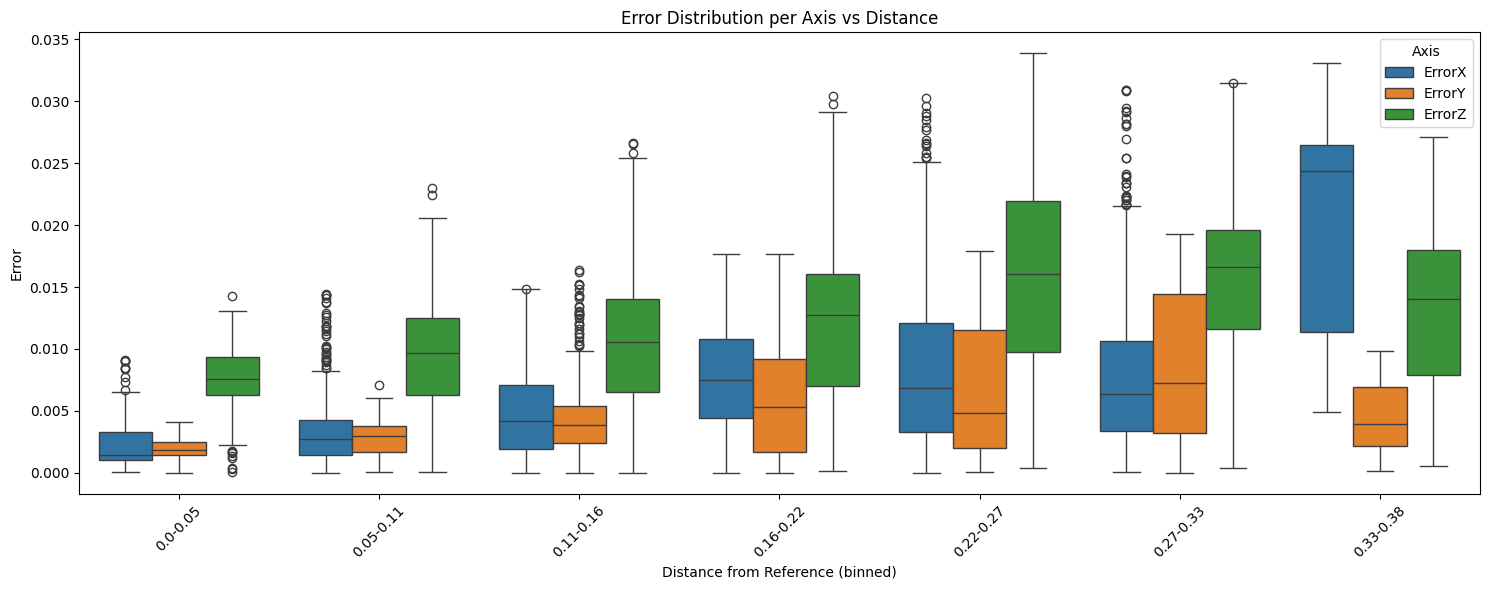

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Error components
error_x = error[:, 0]
error_y = error[:, 1]
error_z = error[:, 2]

# Bin distances
bins = np.linspace(vector_distance.min(), vector_distance.max(), 8)  # 7 bins
bin_labels = [f"{round(bins[i],2)}-{round(bins[i+1],2)}" for i in range(len(bins)-1)]
binned_dist = pd.cut(vector_distance, bins=bins, labels=bin_labels, include_lowest=True)

# Build dataframe for plotting
err_df = pd.DataFrame({
    "DistanceBin": binned_dist,
    "ErrorX": np.abs(error_x),
    "ErrorY": np.abs(error_y),
    "ErrorZ": np.abs(error_z)
})

# Melt into long format (needed for grouped boxplots)
err_long = err_df.melt(id_vars="DistanceBin", 
                       value_vars=["ErrorX", "ErrorY", "ErrorZ"],
                       var_name="Axis", value_name="Error")

# Plot
plt.figure(figsize=(15, 6))
sns.boxplot(x="DistanceBin", y="Error", hue="Axis", data=err_long)
plt.title("Error Distribution per Axis vs Distance")
plt.xlabel("Distance from Reference (binned)")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.legend(title="Axis")
plt.tight_layout()
plt.show()


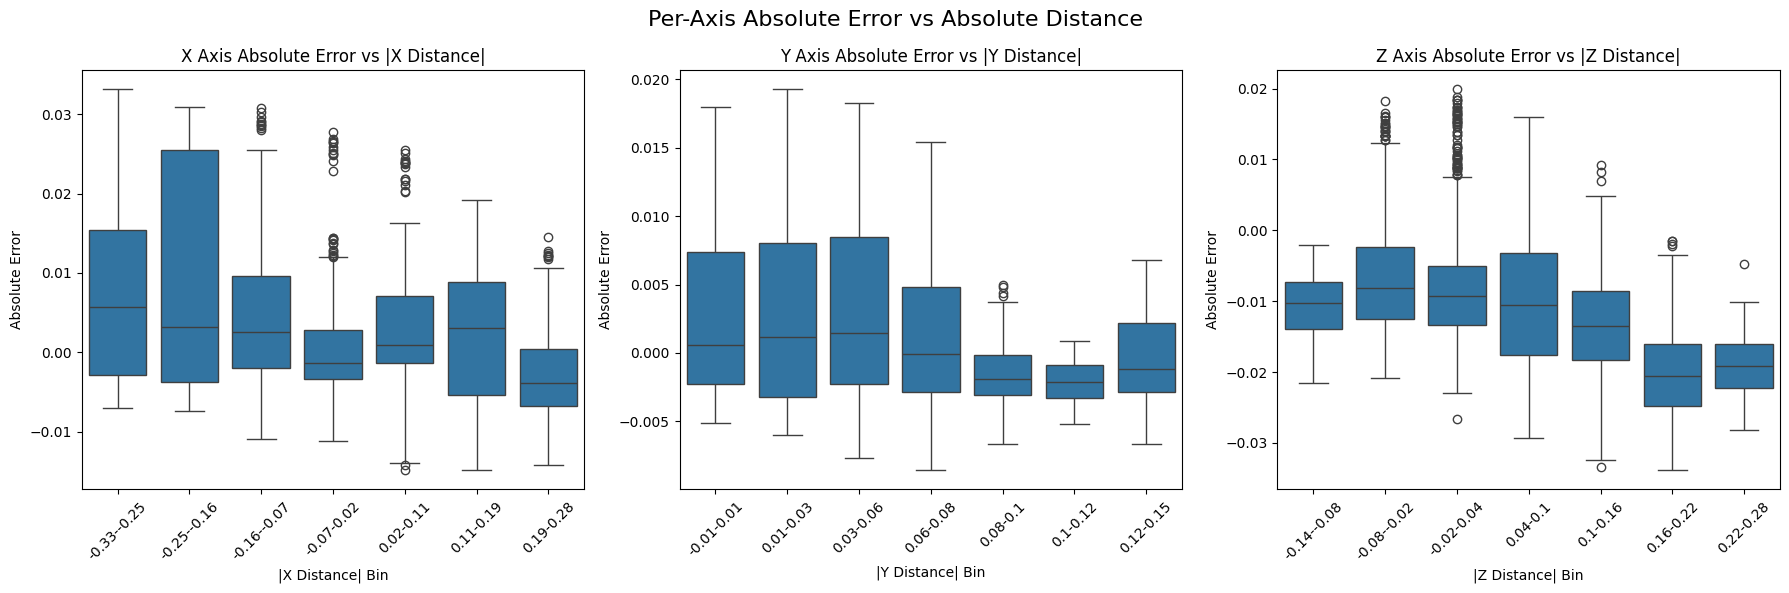

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Absolute error ---
error = transformed_rb_pos - vector
error_x = error[:, 0]
error_y = error[:, 1]
error_z = error[:, 2]

# --- Absolute axis-specific distances ---
x_distance = vector[:, 0] - vector[0, 0]
y_distance = vector[:, 1] - vector[0, 1]
z_distance = vector[:, 2] - vector[0, 2]

# Bin each axis separately
bins_x = np.linspace(x_distance.min(), x_distance.max(), 8)
bins_y = np.linspace(y_distance.min(), y_distance.max(), 8)
bins_z = np.linspace(z_distance.min(), z_distance.max(), 8)

binned_x = pd.cut(x_distance, bins=bins_x, 
                  labels=[f"{round(bins_x[i],2)}-{round(bins_x[i+1],2)}" for i in range(len(bins_x)-1)],
                  include_lowest=True)
binned_y = pd.cut(y_distance, bins=bins_y, 
                  labels=[f"{round(bins_y[i],2)}-{round(bins_y[i+1],2)}" for i in range(len(bins_y)-1)],
                  include_lowest=True)
binned_z = pd.cut(z_distance, bins=bins_z, 
                  labels=[f"{round(bins_z[i],2)}-{round(bins_z[i+1],2)}" for i in range(len(bins_z)-1)],
                  include_lowest=True)

# Build per-axis dataframes
err_x_df = pd.DataFrame({"DistanceBin": binned_x, "Error": error_x})
err_y_df = pd.DataFrame({"DistanceBin": binned_y, "Error": error_y})
err_z_df = pd.DataFrame({"DistanceBin": binned_z, "Error": error_z})

# ---- Plot per-axis subplots ----
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

sns.boxplot(x="DistanceBin", y="Error", data=err_x_df, ax=axes[0])
axes[0].set_title("X Axis Absolute Error vs |X Distance|")
axes[0].set_xlabel("|X Distance| Bin")
axes[0].set_ylabel("Absolute Error")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x="DistanceBin", y="Error", data=err_y_df, ax=axes[1])
axes[1].set_title("Y Axis Absolute Error vs |Y Distance|")
axes[1].set_xlabel("|Y Distance| Bin")
axes[1].set_ylabel("Absolute Error")
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x="DistanceBin", y="Error", data=err_z_df, ax=axes[2])
axes[2].set_title("Z Axis Absolute Error vs |Z Distance|")
axes[2].set_xlabel("|Z Distance| Bin")
axes[2].set_ylabel("Absolute Error")
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle("Per-Axis Absolute Error vs Absolute Distance", fontsize=16)
plt.tight_layout()
